# Financial Dataset for AAPL

In [ ]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
# sns.set_style('whitegrid')
# plt.style.use("fivethirtyeight")
%matplotlib inline

# For reading stock data from yahoo
from pandas_datareader.data import DataReader
import yfinance as yf
from pandas_datareader import data as pdr

yf.pdr_override()

# For time stamps
from datetime import datetime


In [ ]:
end = datetime.now()
start = datetime(end.year - 20, end.month, end.day)

data = yf.download('AAPL' , start, end)

[*********************100%%**********************]  1 of 1 completed


In [ ]:
data

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2003-12-03,0.384643,0.390000,0.374286,0.375536,0.318334,191296000
2003-12-04,0.373929,0.378036,0.370893,0.377679,0.320151,177940000
2003-12-05,0.373214,0.377679,0.370179,0.372321,0.315609,186177600
2003-12-08,0.371071,0.376429,0.364464,0.375893,0.318637,148237600
2003-12-09,0.378036,0.379464,0.364286,0.365179,0.309555,135144800
...,...,...,...,...,...,...
2023-11-27,189.919998,190.669998,188.899994,189.789993,189.789993,40552600
2023-11-28,189.779999,191.080002,189.399994,190.399994,190.399994,38415400
2023-11-29,190.899994,192.089996,188.970001,189.369995,189.369995,43014200


Text(0.5, 1.0, 'Closing Price of APPL')

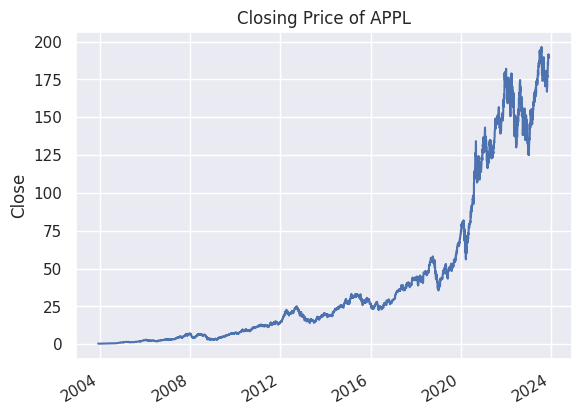

In [ ]:
# Let's see a historical view of the closing price

data['Close'].plot()
plt.ylabel('Close')
plt.xlabel(None)
plt.title(f"Closing Price of APPL")

In [ ]:
from sklearn.model_selection import train_test_split
data_train, data_test = train_test_split(data['Close'], test_size=0.2, shuffle=False)
data_train, data_test = pd.Series(data_train), pd.Series(data_test)

In [ ]:
data = data.resample('B').ffill()

<Figure size 1500x800 with 0 Axes>

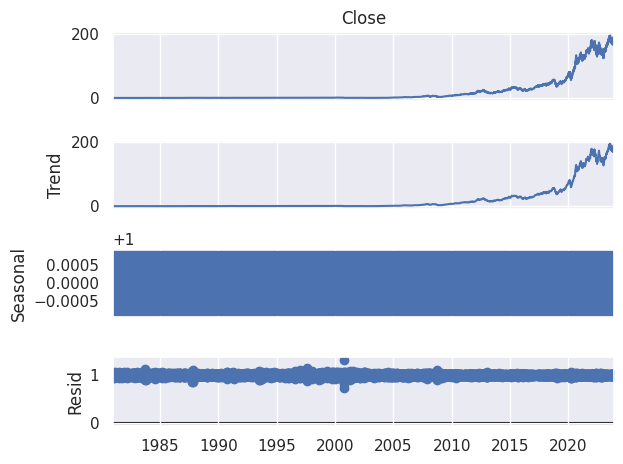

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose
plt.figure(figsize=(15, 8))
result = seasonal_decompose(data['Close'], model='multiplicative')
result.plot()
plt.show()

## ARIMA

### Check Stationarity

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

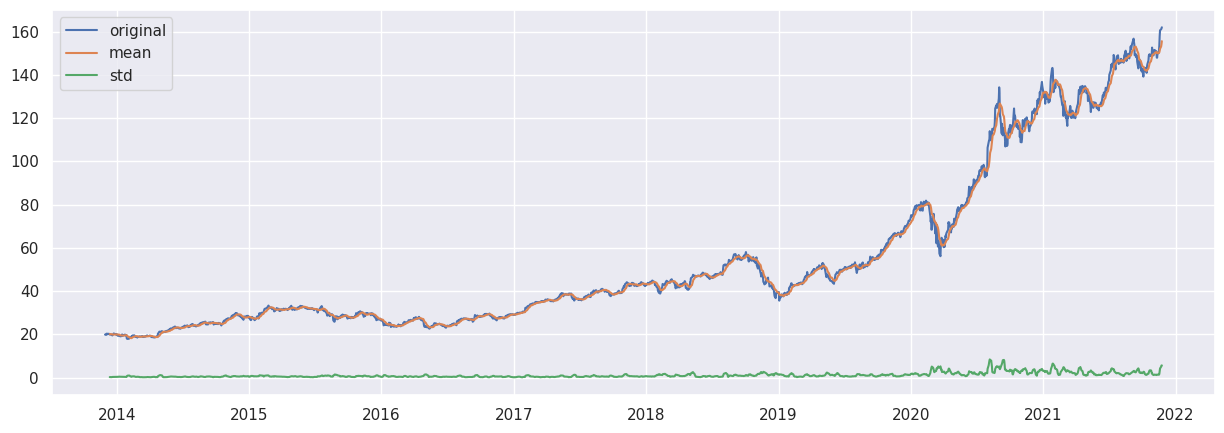

In [ ]:
# Rolling Average Test
roll_mean = data_train.rolling(window=10).mean()
roll_std = data_train.rolling(window=10).std()
plt.figure(figsize=(15, 5))
plt.plot(data_train , label='original')
plt.plot(roll_mean, label='mean')
plt.plot(roll_std, label='std')
plt.legend()
plt.show()

Variance is constant but not mean, hence the data is not stationary. To make dataset stationary, shift the dataset by 1 and then subtract

In [ ]:
data_diff = data_train- data_train.shift(1)
data_diff.head()

Date
2013-11-29         NaN
2013-12-02   -0.172857
2013-12-03    0.538927
2013-12-04   -0.047142
2013-12-05    0.103571
Name: Close, dtype: float64

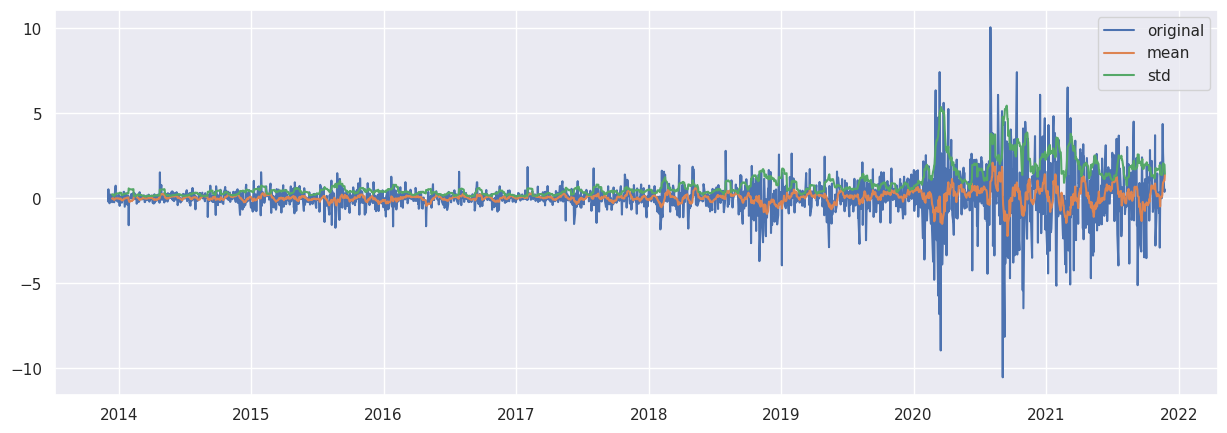

In [ ]:
# Rolling Average Test
roll_mean = data_diff.rolling(window=10).mean()
roll_std = data_diff.rolling(window=10).std()
plt.figure(figsize=(15, 5))
plt.plot(data_diff, label='original')
plt.plot(roll_mean, label='mean')
plt.plot(roll_std, label='std')
plt.legend()
plt.show()

The mean and variance both look unchanging now. We can conduct ADF Test to be sure to check if the data is now stationary or not

In [ ]:
from statsmodels.tsa.stattools import adfuller
ad = adfuller(data_diff.dropna(), autolag='AIC')
names = ['adf', 'pvalue', 'used_lags', 'nobs', 'critical_values']
for x, y in zip(names, ad):
    print(f'{x}: {y}')

adf: -8.954431268482105
pvalue: 8.549841268322059e-15
used_lags: 26
nobs: 1984
critical_values: {'1%': -3.4336502927748587, '5%': -2.8629978852039737, '10%': -2.5675461168480913}


### ACF And PACF

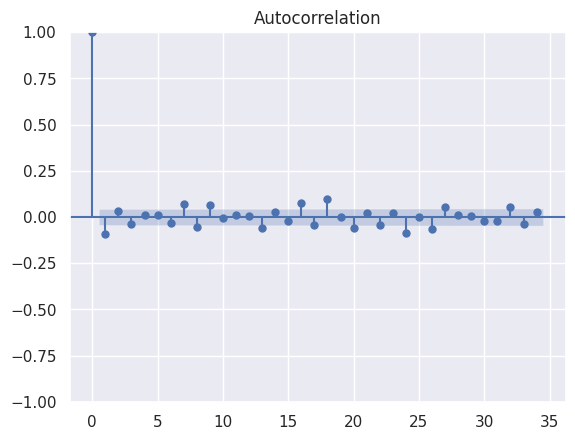

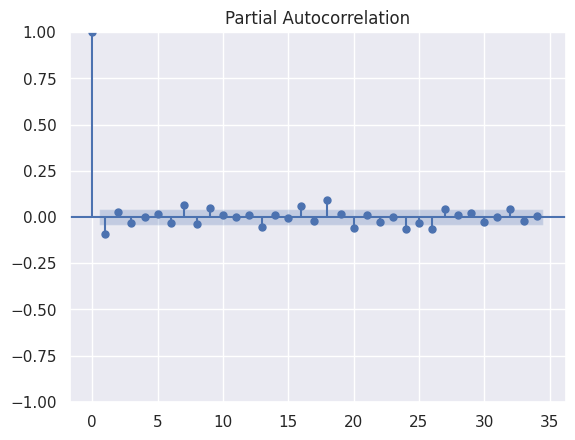

In [ ]:
from statsmodels.tsa.stattools import pacf, acf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

ppacf = pacf(data_diff.dropna(), nlags=40)
aacf = acf(data_diff.dropna(), nlags=40)

plot_acf(data_diff.dropna())
plot_pacf(data_diff.dropna())
plt.show()

### Training

In [ ]:
import warnings
warnings.filterwarnings('ignore')

from statsmodels.tsa.arima.model import ARIMA
model = ARIMA(data_train, order=(1, 1, 1))
results = model.fit()
pred = results.fittedvalues
data_train_pred = pd.Series(pred)
data_train_pred

Date
2013-11-29      0.000000
2013-12-02     19.859641
2013-12-03     19.702581
2013-12-04     20.172314
2013-12-05     20.202401
                 ...    
2021-11-18    153.311133
2021-11-19    157.551348
2021-11-22    160.432170
2021-11-23    161.022183
2021-11-24    161.374955
Length: 2012, dtype: float64

In [ ]:
results.predict(0, len(data_train))

0         0.000000
1        19.859641
2        19.702581
3        20.172314
4        20.202401
           ...    
2008    157.551348
2009    160.432170
2010    161.022183
2011    161.374955
2012    161.906387
Name: predicted_mean, Length: 2013, dtype: float64

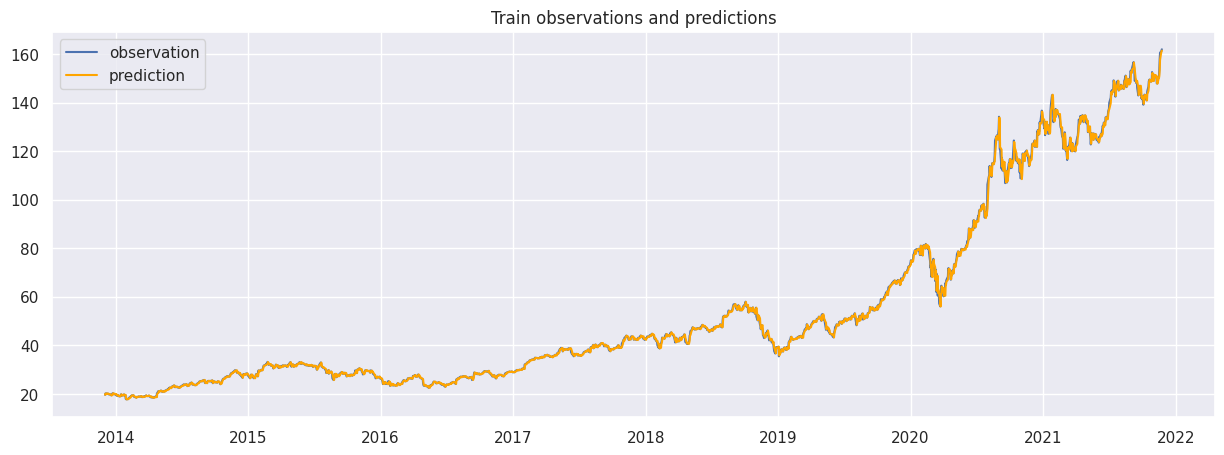

In [ ]:
plt.figure(figsize=(15, 5))
plt.plot(data_train[1:], label='observation')
plt.plot(data_train_pred[1:], c='orange', label='prediction')
plt.title('Train observations and predictions')
plt.legend()
plt.show()

### Prediction

#### Single Step

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error,
import math

history = [x for x in data_train]
predictions_single = []
for i in range(len(data_test)):
    model = ARIMA(history, order=(1, 1, 1))
    results = model.fit()
    output = results.forecast()
    res = output[0]
    predictions_single.append(res)
    obs = data_test[i]
    history.append(obs)
    if i % 20 == 0:
        print(f'Iteration: {i} | Predicted: {res:.3f} | Expected: {obs:.3f}')

Iteration: 0 | Predicted: 161.906 | Expected: 156.810
Iteration: 20 | Predicted: 176.264 | Expected: 180.330
Iteration: 40 | Predicted: 161.639 | Expected: 159.780
Iteration: 60 | Predicted: 164.472 | Expected: 160.070
Iteration: 80 | Predicted: 168.678 | Expected: 170.210
Iteration: 100 | Predicted: 167.212 | Expected: 166.420
Iteration: 120 | Predicted: 141.504 | Expected: 137.350
Iteration: 140 | Predicted: 130.338 | Expected: 131.560
Iteration: 160 | Predicted: 147.202 | Expected: 151.000
Iteration: 180 | Predicted: 173.075 | Expected: 173.030
Iteration: 200 | Predicted: 154.341 | Expected: 155.310
Iteration: 220 | Predicted: 139.096 | Expected: 138.340
Iteration: 240 | Predicted: 139.490 | Expected: 134.870
Iteration: 260 | Predicted: 141.178 | Expected: 142.650
Iteration: 280 | Predicted: 129.383 | Expected: 130.150
Iteration: 300 | Predicted: 151.731 | Expected: 154.650
Iteration: 320 | Predicted: 151.600 | Expected: 152.870
Iteration: 340 | Predicted: 165.589 | Expected: 163.76

In [ ]:
data_test

Date
2021-11-26    156.809998
2021-11-29    160.240005
2021-11-30    165.300003
2021-12-01    164.770004
2021-12-02    163.759995
                 ...    
2023-11-21    190.639999
2023-11-22    191.309998
2023-11-24    189.970001
2023-11-27    189.789993
2023-11-28    190.399994
Name: Close, Length: 504, dtype: float64

In [ ]:
rmse = math.sqrt(mean_squared_error(data_test, predictions_single))
mae = mean_absolute_error(data_test, predictions_single)
mse = mean_squared_error(data_test, predictions_single)

print(f'Test RMSE: {rmse:.3f}')
print(f'Test MAE: {mae:.3f}')
print(f'Test MSE: {mse:.3f}')

Test RMSE: 2.938
Test MAE: 2.236
Test MSE: 8.633


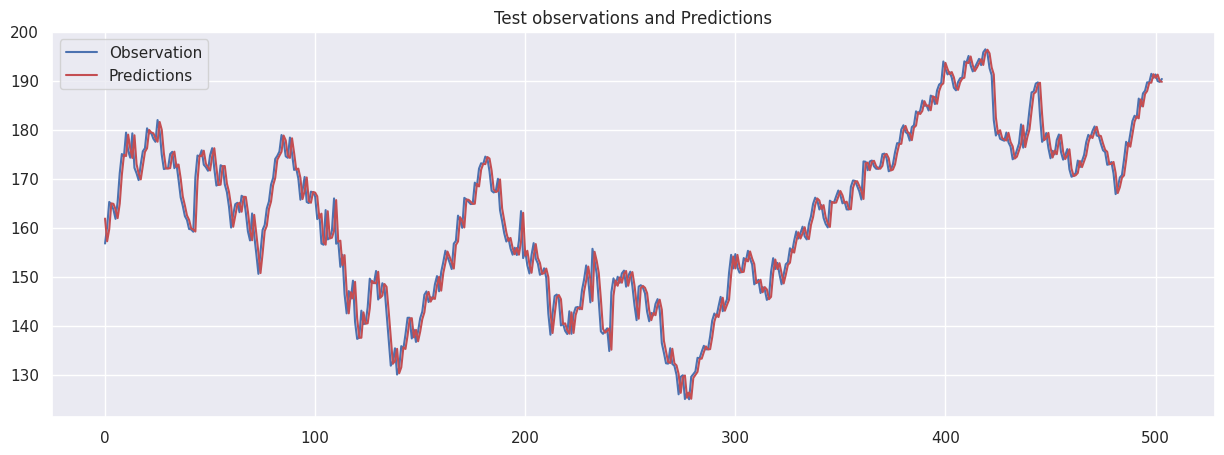

In [ ]:
plt.figure(figsize=(15, 5))
plt.plot(list(data_test), label='Observation')
plt.plot(predictions_single, c='r', label='Predictions')
plt.title('Test observations and Predictions')
plt.legend()
plt.show()

In [ ]:
from sklearn.metrics import mean_squared_error
import math

history = [x for x in data_train]
predictions_multiple = []
sstep = 15

for i in range(0, len(data_test), sstep):
    model = ARIMA(history, order=(3, 1, 2))
    results = model.fit()
    if i+sstep-1 < len(data_test):
        output = results.forecast(sstep)
        predictions_multiple.extend(output)
        obs = list(data_test[i:i+sstep])
        history.extend(obs)
    else:
        output = results.forecast(len(data_test) - i)
        predictions_multiple.extend(output)
        obs = list(data_test[i:len(data_test) - i])
        history.append(obs)
    if i % 20 == 0:
        print(f'Iteration: {i} | Predicted: {output} | Expected: {obs}')

Iteration: 0 | Predicted: [161.93754703 162.02676549 161.88622313 161.94032748 162.02665301
 161.88816239 161.93812193 162.02692446 161.8900875  161.93596345
 162.0271263  161.89203744 161.93384958 162.0272597  161.89401013] | Expected: [156.80999755859375, 160.24000549316406, 165.3000030517578, 164.77000427246094, 163.75999450683594, 161.83999633789062, 165.32000732421875, 171.17999267578125, 175.0800018310547, 174.55999755859375, 179.4499969482422, 175.74000549316406, 174.3300018310547, 179.3000030517578, 172.25999450683594]
Iteration: 60 | Predicted: [164.45721475 164.81024228 165.12792378 164.99005268 164.58931375
 164.44566513 164.73352576 165.07102806 165.02604908 164.66902611
 164.46594709 164.67054209 165.00794991 165.043325   164.7418769 ] | Expected: [160.07000732421875, 162.74000549316406, 164.85000610351562, 165.1199951171875, 163.1999969482422, 166.55999755859375, 166.22999572753906, 163.1699981689453, 159.3000030517578, 157.44000244140625, 162.9499969482422, 158.520004272

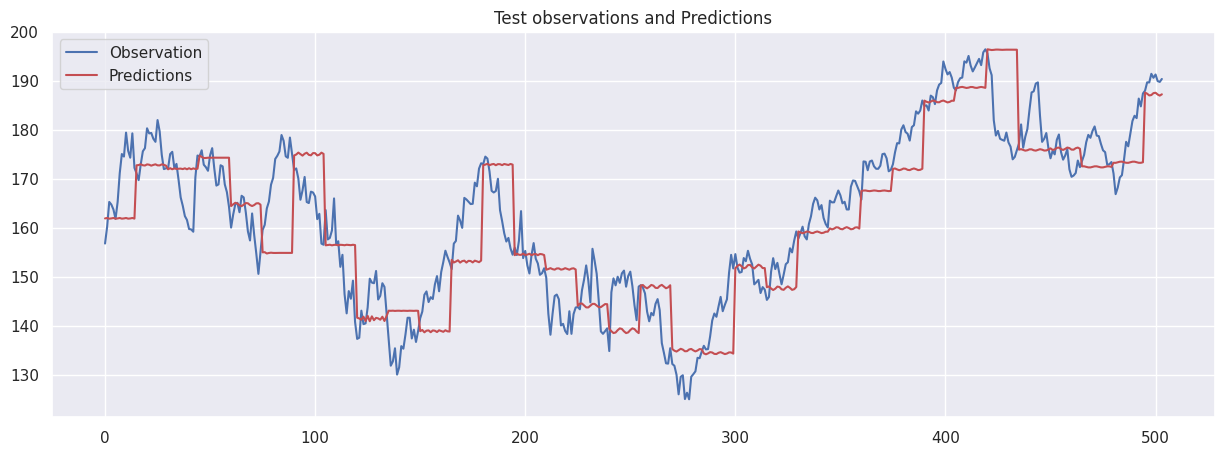

In [ ]:
plt.figure(figsize=(15, 5))
plt.plot(list(data_test), label='Observation')
plt.plot(predictions_multiple, c='r', label='Predictions')
plt.title('Test observations and Predictions')
plt.legend()
plt.show()

-----


-----



-----



In [ ]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
sns.set()
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

In [ ]:
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = data['Close'].to_numpy().reshape(-1,1)
dataset = scaler.fit_transform(dataset)
train_size = int(len(dataset) * 0.8)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
print(len(train), len(test))

2012 503


In [ ]:
# train = data_train.to_numpy()
# test = data_test.to_numpy()

In [ ]:
# train = train.reshape(-1,1)
# test = test.reshape(-1,1)

In [ ]:
def create_dataset(dataset, look_back=1):
 dataX, dataY = [], []
 for i in range(len(dataset)-look_back-1):
  a = dataset[i:(i+look_back), 0]
  dataX.append(a)
  dataY.append(dataset[i + look_back, 0])
 return np.array(dataX), np.array(dataY)

In [ ]:
look_back = 3
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

In [ ]:
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [ ]:
hidden_size = 50
output_size = 1

model = Sequential()
model.add(LSTM(hidden_size, input_shape=(1, look_back)))
model.add(Dense(output_size))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=30, batch_size=1, verbose=2)

Epoch 1/30
2008/2008 - 10s - loss: 0.0025 - 10s/epoch - 5ms/step
Epoch 2/30
2008/2008 - 5s - loss: 1.0645e-04 - 5s/epoch - 2ms/step
Epoch 3/30
2008/2008 - 6s - loss: 1.1574e-04 - 6s/epoch - 3ms/step
Epoch 4/30
2008/2008 - 7s - loss: 1.1372e-04 - 7s/epoch - 4ms/step
Epoch 5/30
2008/2008 - 10s - loss: 1.1568e-04 - 10s/epoch - 5ms/step
Epoch 6/30
2008/2008 - 10s - loss: 1.0409e-04 - 10s/epoch - 5ms/step
Epoch 7/30
2008/2008 - 7s - loss: 1.0843e-04 - 7s/epoch - 3ms/step
Epoch 8/30
2008/2008 - 5s - loss: 1.0432e-04 - 5s/epoch - 2ms/step
Epoch 9/30
2008/2008 - 6s - loss: 1.0856e-04 - 6s/epoch - 3ms/step
Epoch 10/30
2008/2008 - 4s - loss: 1.0028e-04 - 4s/epoch - 2ms/step
Epoch 11/30
2008/2008 - 5s - loss: 9.9112e-05 - 5s/epoch - 2ms/step
Epoch 12/30
2008/2008 - 6s - loss: 1.0581e-04 - 6s/epoch - 3ms/step
Epoch 13/30
2008/2008 - 4s - loss: 9.7490e-05 - 4s/epoch - 2ms/step
Epoch 14/30
2008/2008 - 4s - loss: 9.7882e-05 - 4s/epoch - 2ms/step
Epoch 15/30
2008/2008 - 6s - loss: 9.0892e-05 - 6s/epoc

16/16 [==============================] - 0s 4ms/step
Root Mean Squared Error (RMSE): 35.36502730556624


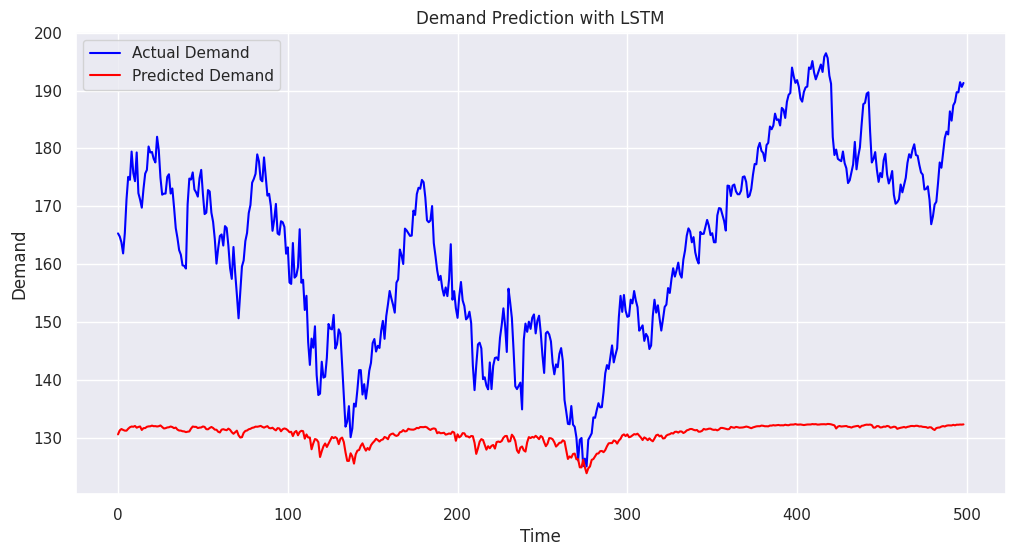

In [ ]:
testPredict = model.predict(testX)

# Invert predictions back to original scale
testPredict = scaler.inverse_transform(testPredict.reshape(-1, 1))
testY = scaler.inverse_transform(testY.reshape(-1, 1))

# Calculate RMSE (Root Mean Squared Error)
rmse = np.sqrt(mean_squared_error(testY, testPredict))
print(f"Root Mean Squared Error (RMSE): {rmse}")

# Plotting the predictions
plt.figure(figsize=(12, 6))
plt.plot(testY, label='Actual Demand', color='blue')
plt.plot(testPredict, label='Predicted Demand', color='red')
plt.title('Demand Prediction with LSTM')
plt.xlabel('Time')
plt.ylabel('Demand')
plt.legend()
plt.show()

## CNN

In [ ]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

import torch
import torch.nn as nn

from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split
import math

#Tensorflow
import tensorflow as tf
from tensorflow.keras import models
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Dense, Flatten
from sklearn.preprocessing import MinMaxScaler

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd drive/MyDrive/"Sem 1"/ML/Project/

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
[Errno 2] No such file or directory: 'drive/MyDrive/Sem 1/ML/Project/'
/content/drive/MyDrive/Sem 1/ML/Project


In [ ]:
from pandas_datareader.data import DataReader
import yfinance as yf
from pandas_datareader import data as pdr

yf.pdr_override()

# For time stamps
from datetime import datetime

end = datetime.now()
start = datetime(end.year - 10, end.month, end.day)

data = yf.download('AAPL' , start, end)

[*********************100%%**********************]  1 of 1 completed


In [ ]:
##Converting to input data

def data_prep_1d(X, seq_len):

  X_1d = []
  y_1d = []

  for i in range(len(X)-seq_len):

    X_1d.append(X[i:i+seq_len])
    y_1d.append(X[i+seq_len])

  return X_1d, y_1d


In [ ]:
financial_data = np.array(data['Close'])

X1, y1 = data_prep_1d(financial_data, 10)

X_train, X_test, y_train, y_test = train_test_split(X1, y1, test_size=0.2, shuffle=False)

X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)

n_steps = 10
n_features = 1

X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], n_features))
X_train.shape

X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], n_features))


In [ ]:
# from tensorflow.keras import models
# from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense

model = models.Sequential()
model.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(n_steps, n_features)))
model.add(Conv1D(filters=128, kernel_size=2, activation='relu'))
model.add(MaxPooling1D(pool_size=2))

model.add(Conv1D(filters=256, kernel_size=2, activation='relu'))

model.add(Conv1D(filters=512, kernel_size=2, activation='relu'))
model.add(MaxPooling1D(pool_size=2))

model.add(Flatten())
model.add(Dense(100, activation='relu'))
model.add(Dense(50, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

model.fit(X_train, y_train, epochs=100)

Epoch 1/100
63/63 [==============================] - 4s 35ms/step - loss: 276.3557
Epoch 2/100
63/63 [==============================] - 2s 37ms/step - loss: 6.4793
Epoch 3/100
63/63 [==============================] - 2s 35ms/step - loss: 7.7724
Epoch 4/100
63/63 [==============================] - 2s 35ms/step - loss: 9.5229
Epoch 5/100
63/63 [==============================] - 2s 37ms/step - loss: 10.2301
Epoch 6/100
63/63 [==============================] - 3s 51ms/step - loss: 7.1291
Epoch 7/100
63/63 [==============================] - 3s 52ms/step - loss: 6.9719
Epoch 8/100
63/63 [==============================] - 3s 45ms/step - loss: 7.3815
Epoch 9/100
63/63 [==============================] - 2s 36ms/step - loss: 7.7606
Epoch 10/100
63/63 [==============================] - 2s 34ms/step - loss: 7.0845
Epoch 11/100
63/63 [==============================] - 2s 34ms/step - loss: 6.4302
Epoch 12/100
63/63 [==============================] - 2s 34ms/step - loss: 6.2574
Epoch 13/100
63/63 [==

16/16 [==============================] - 0s 8ms/step


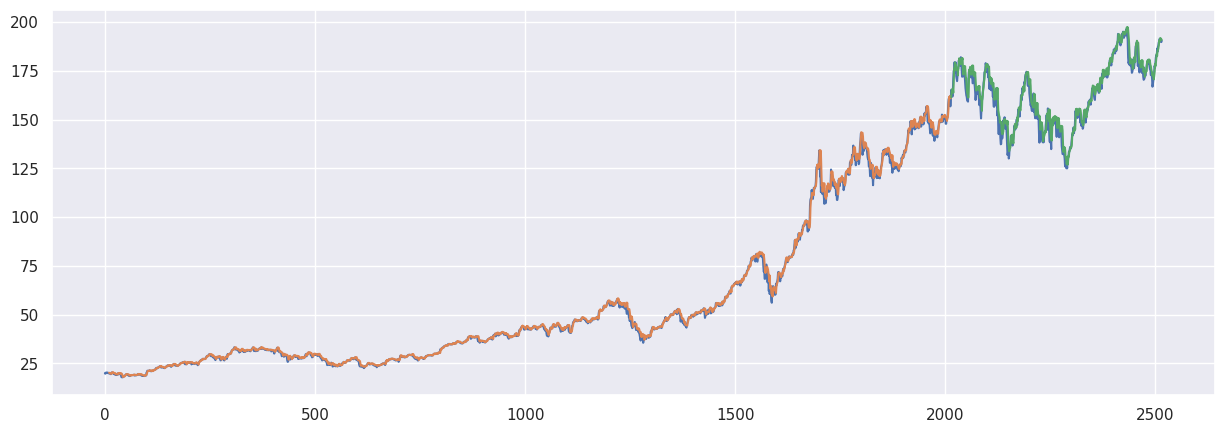

Test MAE: 3.312
Test MSE: 19.427
Test RMSE: 4.408


In [ ]:
y_pred = model.predict(X_train)
y_pred_test = model.predict(X_test)

rmse = math.sqrt(mean_squared_error(y_test, y_pred_test))
mae = mean_absolute_error(y_test, y_pred_test)
mse = mean_squared_error(y_test, y_pred_test)

plt.figure(figsize=(15, 5))

plt.plot(np.array(financial_data))

plt.plot(range(10, len(y_pred)+10), y_pred)

plt.plot(range(len(y_pred)+10, len(y_pred)+len(y_pred_test)+10), y_pred_test)

# plt.title('Sine Wave + Noise')
plt.show()

print(f'Test MAE: {mae:.3f}')
print(f'Test MSE: {mse:.3f}')
print(f'Test RMSE: {rmse:.3f}')

In [ ]:
#Forecasting for 2 time step

def predict_n_step(X, y,  n):
  yp = []

  for i in range(X.shape[0]):
    if(i%n <= n_steps):
      yp.append( model.predict( np.append(X[i][0:n_steps-(i%n)], yp[len(yp)-(i%n):len(yp)]).reshape(1,n_steps,1) )[0][0] )
    else:
      yp.append( model.predict( np.array(yp[-n_steps:]).reshape(1,n_steps,1) )[0][0] )

    if(i!=0 and i%n==0):
      model.fit(X[i-n:i], y[i-n:i], epochs=3)
  return yp

1/1 [==============================] - 0s 22ms/step
Epoch 1/3
1/1 [==============================] - 0s 19ms/step - loss: 15.3329
Epoch 2/3
1/1 [==============================] - 0s 16ms/step - loss: 459.2635
Epoch 3/3
1/1 [==============================] - 0s 26ms/step
Epoch 1/3
1/1 [==============================] - 0s 18ms/step - loss: 115.2769
Epoch 2/3
1/1 [==============================] - 0s 19ms/step - loss: 1517.0048
Epoch 3/3
1/1 [==============================] - 0s 23ms/step
Epoch 1/3
1/1 [==============================] - 0s 19ms/step - loss: 833.7868
Epoch 2/3
1/1 [==============================] - 0s 21ms/step - loss: 532.1140
Epoch 3/3
1/1 [==============================] - 0s 27ms/step
Epoch 1/3
1/1 [==============================] - 0s 18ms/step - loss: 898.8871
Epoch 2/3
1/1 [==============================] - 0s 18ms/step - loss: 23.5646
Epoch 3/3
1/1 [==============================] - 0s 25ms/step
Epoch 1/3
1/1 [==============================] - 0s 18ms/step - loss:

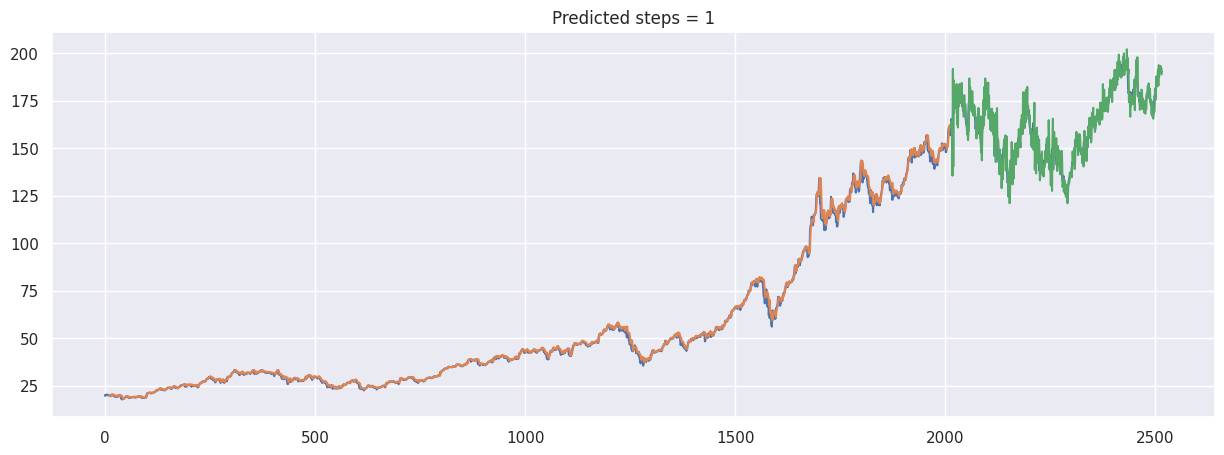

Test MAE: 4.793
Test MSE: 40.067
Test RMSE: 6.330


In [ ]:
yp1 = predict_n_step(X_test, y_test, 1)

rmse = math.sqrt(mean_squared_error(y_test, yp1))
mae = mean_absolute_error(y_test, yp1)
mse = mean_squared_error(y_test, yp1)

plt.figure(figsize=(15, 5))

plt.plot(np.array(financial_data))

plt.plot(range(10, len(y_pred)+10), y_pred)

plt.plot(range(len(y_pred)+10, len(y_pred)+len(yp1)+10), yp1)

plt.title('Predicted steps = 1')
plt.show()

print(f'Test MAE: {mae:.3f}')
print(f'Test MSE: {mse:.3f}')
print(f'Test RMSE: {rmse:.3f}')

In [ ]:
yp2 = predict_n_step(X_test, y_test, 2)

rmse = math.sqrt(mean_squared_error(y_test, yp2))
mae = mean_absolute_error(y_test, yp2)
mse = mean_squared_error(y_test, yp2)

plt.figure(figsize=(15, 5))

plt.plot(np.array(financial_data))

plt.plot(range(10, len(y_pred)+10), y_pred)

plt.plot(range(len(y_pred)+10, len(y_pred)+len(yp2)+10), yp2)

plt.title('Predicted steps = 2')
plt.show()

print(f'Test MAE: {mae:.3f}')
print(f'Test MSE: {mse:.3f}')
print(f'Test RMSE: {rmse:.3f}')

In [ ]:
yp3 = predict_n_step(X_test, y_test, 5)

rmse = math.sqrt(mean_squared_error(y_test, yp3))
mae = mean_absolute_error(y_test, yp3)
mse = mean_squared_error(y_test, yp3)

plt.figure(figsize=(15, 5))

plt.plot(np.array(financial_data))

plt.plot(range(10, len(y_pred)+10), y_pred)

plt.plot(range(len(y_pred)+10, len(y_pred)+len(yp3)+10), yp3)

plt.title('Predicted steps = 5')
plt.show()

print(f'Test MAE: {mae:.3f}')
print(f'Test MSE: {mse:.3f}')
print(f'Test RMSE: {rmse:.3f}')

## LSTM

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
sns.set()
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

In [ ]:
data1 = data['Close']
data1 = data1.to_numpy()

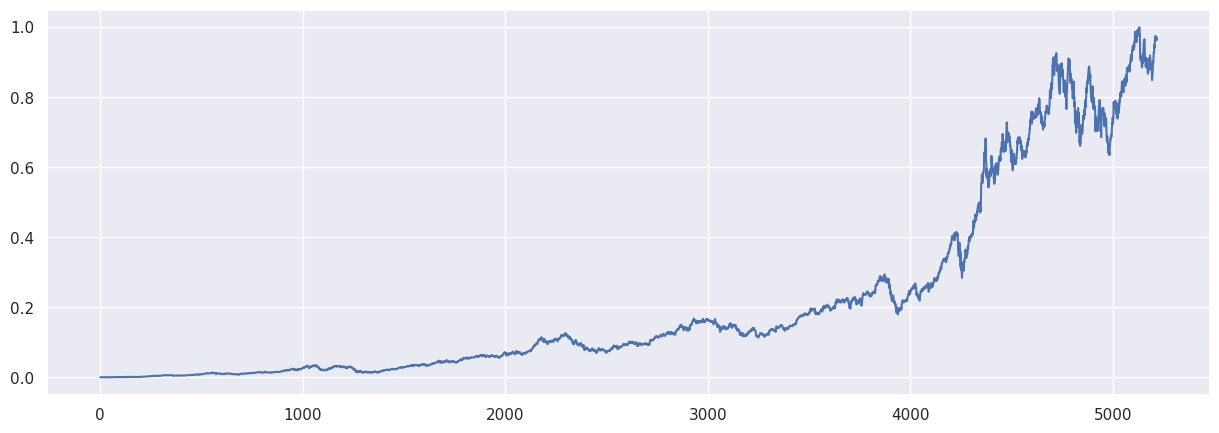

In [ ]:
scaler = MinMaxScaler(feature_range=(0, 1))
data1 = data1.reshape(-1,1)
dataset = scaler.fit_transform(data1)
plt.figure(figsize=(15, 5))
plt.plot(dataset)
plt.show()

## Single Step

In [ ]:
train_size = int(len(dataset) * 0.8)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:train_size + 100,:]
print(len(train), len(test))

4175 100


In [ ]:
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

In [ ]:
look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

In [ ]:
trainX, trainY = np.expand_dims(trainX, axis=1), np.expand_dims(trainY, axis=1)
testX, testY = np.expand_dims(testX, axis=1), np.expand_dims(testY, axis=1)

In [ ]:
from keras.layers import LSTM, Dense, Dropout

# create and fit the LSTM network
model = Sequential()
model.add(LSTM(units=128, input_shape=(1, look_back)))
# model.add(Dense(units=4, activation='relu'))  # Adjust activation function based on your problem
model.add(Dense(units=1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=100, verbose=0)

In [ ]:
trainPredict = model.predict(trainX)

131/131 [==============================] - 1s 2ms/step


In [ ]:
trainPredict_var = scaler.inverse_transform(trainPredict)
trainY_var = scaler.inverse_transform(trainY)

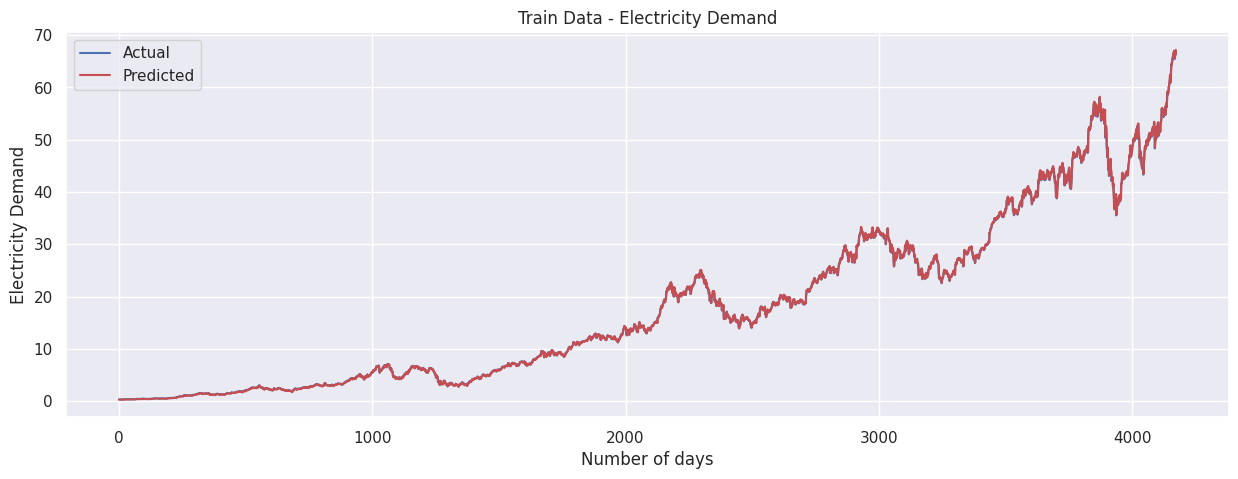

In [ ]:
plt.figure(figsize=(15, 5))
plt.plot(trainY_var, label='Actual')
plt.plot(trainPredict_var, color='r', label='Predicted')

# Additional code for customization (if needed)
plt.legend()
plt.title('Train Data - Electricity Demand')
plt.xlabel('Number of days')
plt.ylabel('Electricity Demand')

# Show the plot
plt.show()

In [ ]:
from sklearn.metrics import mean_squared_error
import math

hstry = trainX.copy()
pred_lstm_single = []
observation_lstm_single = []


for ttest, ttest_y in zip(testX, testY):
    ttest = ttest.reshape(1, ttest.shape[0], ttest.shape[1])
    prediction = model.predict(ttest, verbose=0)

    pred_lstm_single.append(prediction[0][0])
    observation_lstm_single.append(ttest_y)

    model.fit(ttest, ttest_y, epochs=100, verbose=0)

In [ ]:
testPredict_var = scaler.inverse_transform([pred_lstm_single]).T
testY_var = scaler.inverse_transform(testY)

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

rmse = math.sqrt(mean_squared_error(testY_var, testPredict_var))
mae = mean_absolute_error(testY_var, testPredict_var)
mse = mean_squared_error(testY_var, testPredict_var)
mape = mean_absolute_percentage_error(testY_var, testPredict_var)

print(f'Test RMSE: {rmse:.3f}')
print(f'Test MAE: {mae:.3f}')
print(f'Test MSE: {mse:.3f}')
print(f'Test MAPE: {mape:.3f}')

Test RMSE: 3.653
Test MAE: 2.496
Test MSE: 13.343
Test MAPE: 0.036


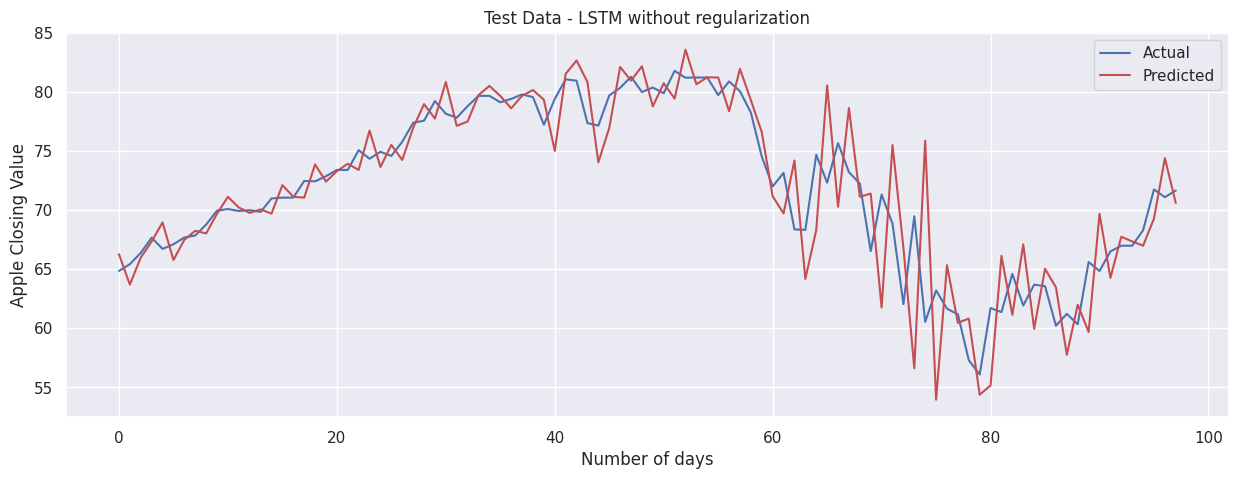

In [ ]:
# plt.figure(figsize=(15, 5))
# plt.plot(testY_var)
# plt.plot(testPredict_var)
plt.figure(figsize=(15, 5))

plt.plot(testY_var, label='Actual')
plt.plot(testPredict_var, color='r', label='Predicted')

# text = f"RMSE: {rmse:.2f}\nMAE: {mae:.2f}\nMAPE: {mape:.2f}%"
# plt.text(0.02, 0.95, text, transform=plt.gca().transAxes, fontsize=10, verticalalignment='top', bbox=dict(facecolor='white', alpha=0.7))

# Additional code for customization (if needed)
plt.legend()
plt.title('Test Data - LSTM without regularization')
plt.xlabel('Number of days')
plt.ylabel('Apple Closing Value')
plt.savefig('without_reg.png')
# Show the plot
plt.show()

---



In [ ]:
train_size = int(len(dataset) * 0.8)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:train_size + 100,:]
print(len(train), len(test))

4175 100


In [ ]:
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

In [ ]:
look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

In [ ]:
trainX, trainY = np.expand_dims(trainX, axis=1), np.expand_dims(trainY, axis=1)
testX, testY = np.expand_dims(testX, axis=1), np.expand_dims(testY, axis=1)

In [ ]:
from keras.layers import LSTM, Dense, Dropout

# create and fit the LSTM network
model = Sequential()
model.add(LSTM(units=128, input_shape=(1, look_back)))
model.add(Dropout(0.2))
# model.add(Dense(units=4, activation='relu'))  # Adjust activation function based on your problem
model.add(Dense(units=1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=100, verbose=0)

In [ ]:
trainPredict = model.predict(trainX)
trainPredict_var = scaler.inverse_transform(trainPredict)
trainY_var = scaler.inverse_transform(trainY)


131/131 [==============================] - 1s 2ms/step


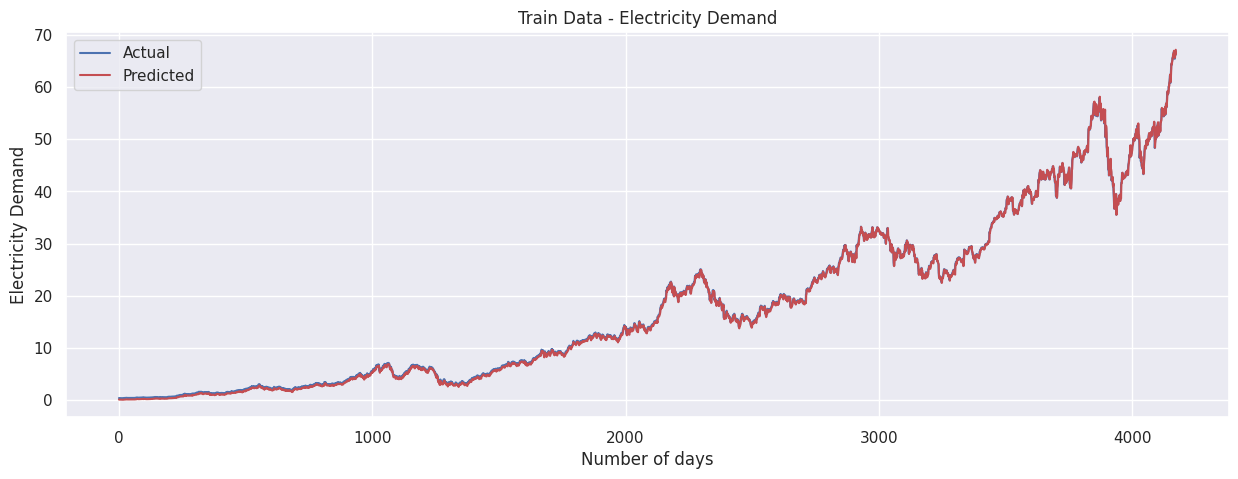

In [ ]:
plt.figure(figsize=(15, 5))
plt.plot(trainY_var, label='Actual')
plt.plot(trainPredict_var, color='r', label='Predicted')

# Additional code for customization (if needed)
plt.legend()
plt.title('Train Data - Electricity Demand')
plt.xlabel('Number of days')
plt.ylabel('Electricity Demand')

# Show the plot
plt.show()

In [ ]:
from sklearn.metrics import mean_squared_error
import math

hstry = trainX.copy()
pred_lstm_single = []
observation_lstm_single = []


for ttest, ttest_y in zip(testX, testY):
    ttest = ttest.reshape(1, ttest.shape[0], ttest.shape[1])
    prediction = model.predict(ttest, verbose=0)

    pred_lstm_single.append(prediction[0][0])
    observation_lstm_single.append(ttest_y)

    model.fit(ttest, ttest_y, epochs=100, verbose=0)

In [ ]:
testPredict_var = scaler.inverse_transform([pred_lstm_single]).T
testY_var = scaler.inverse_transform(testY)

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

rmse = math.sqrt(mean_squared_error(testY_var, testPredict_var))
mae = mean_absolute_error(testY_var, testPredict_var)
mse = mean_squared_error(testY_var, testPredict_var)
mape = mean_absolute_percentage_error(testY_var, testPredict_var)

print(f'Test RMSE: {rmse:.3f}')
print(f'Test MAE: {mae:.3f}')
print(f'Test MSE: {mse:.3f}')
print(f'Test MAPE: {mape:.3f}')

Test RMSE: 2.652
Test MAE: 1.882
Test MSE: 7.033
Test MAPE: 0.027


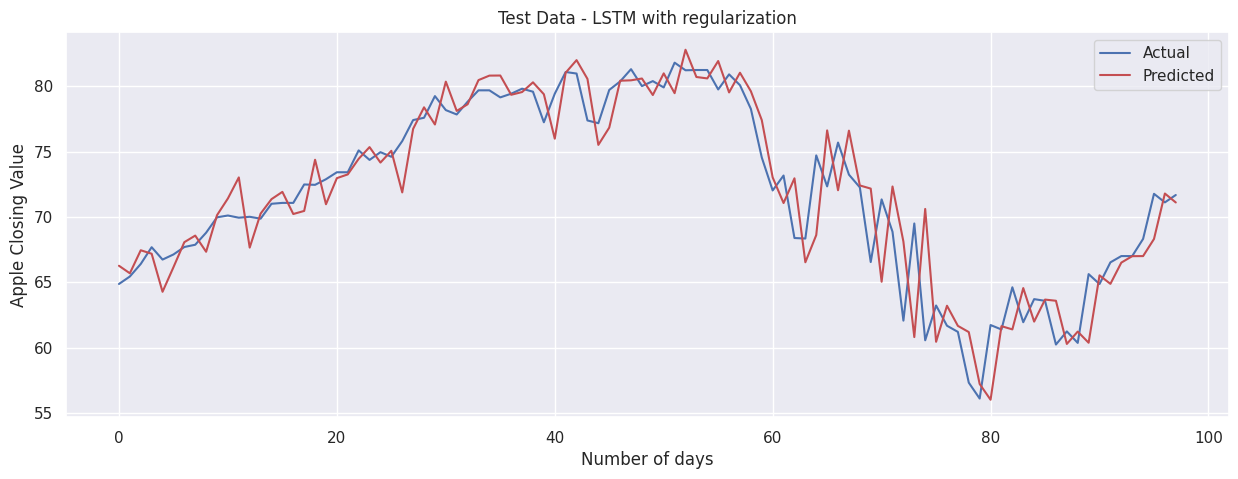

In [ ]:
plt.figure(figsize=(15, 5))

plt.plot(testY_var, label='Actual')
plt.plot(testPredict_var, color='r', label='Predicted')

# text = f"RMSE: {rmse:.2f}\nMAE: {mae:.2f}\nMAPE: {mape:.2f}%"
# plt.text(0.02, 0.95, text, transform=plt.gca().transAxes, fontsize=10, verticalalignment='top', bbox=dict(facecolor='white', alpha=0.7))

# Additional code for customization (if needed)
plt.legend()
plt.title('Test Data - LSTM with regularization')
plt.xlabel('Number of days')
plt.ylabel('Apple Closing Value')
plt.savefig('with_reg.png')

# Show the plot
plt.show()

---


---

In [ ]:
np.random.seed(42)
train_size = int(len(dataset) * 0.8)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
print(len(train), len(test))

4174 1044


In [ ]:
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

In [ ]:
look_back = 10
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)
trainX, trainY = np.expand_dims(trainX, axis=1), np.expand_dims(trainY, axis=1)
testX, testY = np.expand_dims(testX, axis=1), np.expand_dims(testY, axis=1)

In [ ]:
from keras.layers import LSTM, Dense, Dropout

# create and fit the LSTM network
model = Sequential()
model.add(LSTM(units=50, input_shape=(1, look_back)))
# model.add(Dense(units=4, activation='relu'))  # Adjust activation function based on your problem
model.add(Dense(units=1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=100, verbose=0)

In [ ]:
def predict_n_step(model, X, n, n_steps):
  X1 = np.transpose(X, (0, 2, 1))
  yp = []

  for i in range(X1.shape[0]):
    if(i%n <= n_steps):
      yp.append( model.predict( np.append(X1[i][0:n_steps-(i%n)], yp[len(yp)-(i%n):len(yp)]).reshape(1,1,n_steps), verbose=0)[0][0] )
    else:
      yp.append( model.predict( np.array(yp[-n_steps:]).reshape(1,1,n_steps), verbose=0)[0][0] )

  return yp

In [ ]:
from sklearn.metrics import mean_squared_error
import math

hstry = trainX.copy()
predictions_multiple = []
observation_lstm_single = []
sstep = 3

for i in range(0, len(testX), sstep):
    print(i)
    if i + sstep - 1 < len(testX):
        output = predict_n_step(model, testX[i:i+sstep], sstep, look_back)
        predictions_multiple.extend(output)
        obs = np.array(testY[i:i+sstep])
        # hstry = np.concatenate(hstry, np.array(obs))

        model.fit(testX[i: i+sstep], testY[i:i+sstep], epochs=30, verbose=0)
    else:
        output = predict_n_step(model, testX[i:len(testX)], sstep, look_back)
        predictions_multiple.extend(output)
        obs = list(testY[i:len(testY)])
        # hstry = np.concatenate(hstry, np.array(obs))

        model.fit(testX[i:len(testX)], testY[i:len(testY)], epochs=30, verbose=0)

    if i % 5 == 0:
        print(f'Iteration: {i} | Predicted: {output} | Expected: {obs}')

0
Iteration: 0 | Predicted: [0.3487269, 0.35201877, 0.35598296] | Expected: [[0.34898693]
 [0.35499156]
 [0.35569277]]
3
6
9
12
15
Iteration: 15 | Predicted: [0.38222912, 0.38571286, 0.3889594] | Expected: [[0.37739106]
 [0.3804125 ]
 [0.37861497]]
18
21
24
27
30
Iteration: 30 | Predicted: [0.4045762, 0.40508208, 0.40535024] | Expected: [[0.40401038]
 [0.39207761]
 [0.40321997]]
33
36
39
42
45
Iteration: 45 | Predicted: [0.41382754, 0.41472208, 0.41520372] | Expected: [[0.41247555]
 [0.41247555]
 [0.40489005]]
48
51
54
57
60
Iteration: 60 | Predicted: [0.3783804, 0.38035554, 0.3797015] | Expected: [[0.36668215]
 [0.33753861]
 [0.36197787]]
63
66
69
72
75
Iteration: 75 | Predicted: [0.32354927, 0.3244106, 0.32480514] | Expected: [[0.31404272]
 [0.32305605]
 [0.32239311]]
78
81
84
87
90
Iteration: 90 | Predicted: [0.36879912, 0.37146708, 0.37444988] | Expected: [[0.35873969]
 [0.3512562 ]
 [0.3403433 ]]
93
96
99
102
105
Iteration: 105 | Predicted: [0.38686693, 0.3882533, 0.3891867] | Exp

In [ ]:
testPredict_var = scaler.inverse_transform([predictions_multiple]).T
testY_var = scaler.inverse_transform(testY)

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

rmse = math.sqrt(mean_squared_error(testY_var, testPredict_var))
mae = mean_absolute_error(testY_var, testPredict_var)
mse = mean_squared_error(testY_var, testPredict_var)
mape = mean_absolute_percentage_error(testY_var, testPredict_var)

print(f'Test RMSE: {rmse:.3f}')
print(f'Test MAE: {mae:.3f}')
print(f'Test MSE: {mse:.3f}')
print(f'Test MAPE: {mape:.3f}')

Test RMSE: 3.895
Test MAE: 2.915
Test MSE: 15.168
Test MAPE: 0.022


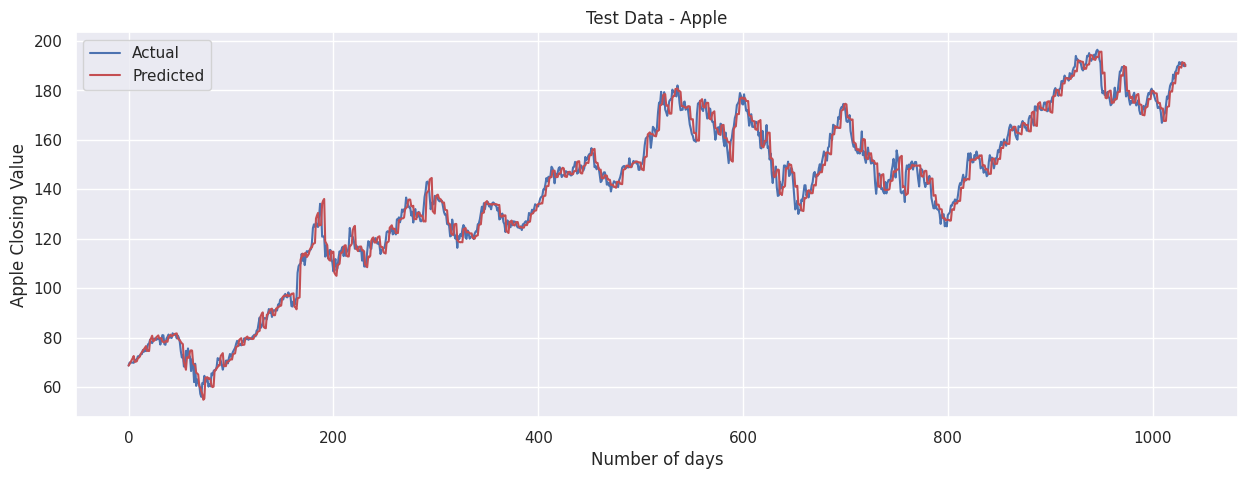

In [ ]:
# plt.figure(figsize=(15, 5))
# plt.plot(testY_var)
# plt.plot(testPredict_var)
plt.figure(figsize=(15, 5))
plt.plot(testY_var, label='Actual')
plt.plot(testPredict_var, color='r', label='Predicted')

# Additional code for customization (if needed)
plt.legend()
plt.title('Test Data - Apple')
plt.xlabel('Number of days')
plt.ylabel('Apple Closing Value')

# Show the plot
plt.show()